In [502]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR10

import random
import numpy as np
import matplotlib.pyplot as plt


import copy

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE, torch.__version__

('cuda', '2.5.1+cu118')

In [504]:
LOWER, UPPER = 0.2, 0.8

In [506]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.CIFAR10(root='data', download=True ,transform=transform, train=True)
test_dataset = datasets.CIFAR10(root='data', download=True ,transform=transform, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [507]:
len(train_dataset)

50000

(32, 32, 3)

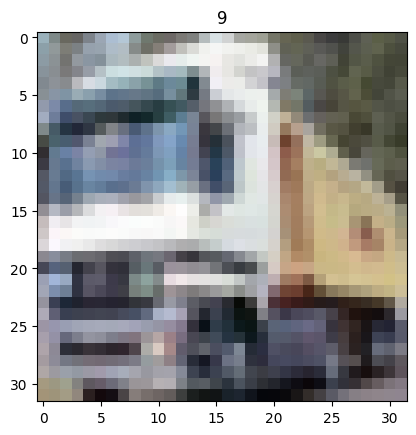

In [508]:
img, lab = train_dataset[1]
img= img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.title(lab)
img.shape

In [509]:
num_classes = len(train_dataset.classes)
num_classes

10

In [525]:
def NoiseLabels(dataset : CIFAR10, lower=LOWER, upper=UPPER, noise_rate=None):
    if noise_rate == None:
        noise_rate = random.uniform(lower, upper)
    
    targets = np.array(dataset.targets)
    n_samples = len(targets)
    noise_bools = np.random.rand(n_samples) < noise_rate
    true_vals = np.sum(noise_bools)

    #
    print(f"Mask Info...\n\tExpected Noise Rate: {noise_rate:.3f} | Actual Noise Rate: {true_vals/len(noise_bools) : .3f} | Samples : {(len(noise_bools))}")

    for i in range(len(noise_bools)):
        if not noise_bools[i]:
            continue

        original_label = targets[i]

        def RandomLabel():
            random_label = np.random.choice(targets)
            return random_label if random_label != original_label else RandomLabel()
        new_label = RandomLabel()
        targets[i] = new_label
    dataset.targets = targets.tolist()

    return dataset
# train_data = datasets.CIFAR10(root='data', download=True, train=True, transform=transform)
train_data_noise = NoiseLabels(copy.deepcopy(train_dataset))


Mask Info...
	Expected Noise Rate: 0.733 | Actual Noise Rate:  0.732 | Samples : 50000


In [448]:

class NoisyDatset(CIFAR10):
    def __init__(self, root='data', transform=None, train=True, download=True, lower=LOWER, upper=UPPER):
            
        super().__init__(root=root, train=train, transform=transform, download=download)
        self.noise_rate = random.uniform(lower, upper)
        # print(f"Randomly chosen noise rate: {self.noise_rate}")
        # self.classes = len(self.classes)
        self.ApplyNoise()
        
    def ApplyNoise(self):
        targets = np.array(self.targets)
        n_samples = len(targets)

        noise_bools = np.random.rand(n_samples) < self.noise_rate
        
        #
        true_vals = np.sum(noise_bools)
        print(f"Mask Info...\n\tExpected Noise Rate: {self.noise_rate:.3f} | Actual Noise Rate: {true_vals/len(noise_bools) : .3f} | True/False : {true_vals/(len(noise_bools) - true_vals) :.3f}")
        
        for i in range(len(noise_bools)):
            if not noise_bools[i]:
                continue
            
            original_label = targets[i]
            new_label = NoisyDatset.__ChooseRandomLabel(original_label, targets)
            targets[i] = new_label
            
            #
            # print(f"Index {i} | {original_label=} | {new_label=}")
            
        self.targets = targets.tolist()
    def __ChooseRandomLabel(original_label, targets):
        new_label = np.random.choice(targets)
        return new_label if new_label != original_label else NoisyDatset.__ChooseRandomLabel(original_label, targets)

In [394]:
train_data_noise = NoisyDatset(root='data', train=True, transform=transform)

Files already downloaded and verified
Mask Info...
	Expected Noise Rate: 0.595 | Actual Noise Rate:  0.594 | True/False : 1.465
